## Kalman Filter
The aim of this notebook is to understand and experiment with Kalman Filters, as a potential improvement upon the current glicko-2 rating system.

### 1. Background
**Assumptions**

A Kalman filter estimates something that cannot be observed directly. It does so by using:
1. A model of how the target quantity evolves over time
2. Noisy samples of the target quantity

The KF then maintains a belief about the hidden state.

The KF assumes that the hidden state evolves over time, $$x_t = Fx_{t-1} + w_t$$ 

where, F is a transition matrix and $w_t$ is a gaussian process noise.

We also assume that our observations are noisy, $$y_t = Hx_t + v_t$$ 

where, H is an observation matrix, that relates the inner state to our observation. $y_t$ is the observed performance, and $v_t$ is a gaussian observation noise.

**Updates**

The updates occur in two steps.

First we build the prior. We estimate our state to be 
$$\hat{x}_{t|t-1} = F\hat{x}_{t-1}.$$ 

Our uncertainty grows from the previous observation, 
$$P_{t|t-1} = FP_{t-1}F^T + Q.$$

Next, we update the understanding with new information. The Kalman Gain, $K_t$, denotes how much the new observation should be trusted vs the prior, given by $$K_t = P_{t|t-1}H^T(HP_{t|t-1}H^T + R)^{-1}.$$

Based on this Kalman Gain, we update the state and uncertainty:
$$\hat{x_{t}} = \hat{x}_{t|t-1} + K_t(y_t - H\hat{x}_{t|t-1})$$
$$P_t = (I - K_tH)P_{t|t-1}$$

Overall, if the uncertainty is high, we trust new data more. If uncertainty is low, we trust the prior more. Each observation also reduces the uncertainty.

### 2. State Construction

In traditional Elo or Glicko-2 skill measurement techniques, the true skill is a number that moves up or down based only on match results and uncertainty. In reality, the result of a match is a noisy measurement of a player's underlying ability, and is influenced by many other factors, including fatigue, surface preference and more.

The simplest state that represents an observation is to include the true skill of both players:
$$x = [s_a, s_b]^T, \space P = \begin{bmatrix} P_A & 0 \\ 0 & P_B \end{bmatrix}$$

Then we propose that true skill is a gaussian random walk: $$s_t=s_{t-1} + w_t,\space w_t \sim N(0, q)$$

The prior hence is constructed as:
$$x^- = x$$
$$P^- = P + Q = \begin{bmatrix} P_A + q & 0 \\ 0 & P_B + q \end{bmatrix}$$

Here we assume the match result is solely driven by the skill difference between the two players. We model the probability that player A wins the match as
$$\hat{y}^- = h(x^-)$$
where we use the logistic elo function
$$h(x) = (1+\exp(-k\begin{bmatrix} 1 & -1 \end{bmatrix}x))^{-1}$$

However, because $h(x)$ is non-linear, we should use the Extended Kalman Filter, and approximate h(x) with the taylor expansion. We thus have,

$$ h(x) \approx  h(x^-) + H(x - x^-)$$
where $H$ is the Jacobian of $h$ evaluated at $x^-$,

$$H = kp^-(1-p^-)\begin{bmatrix} 1 & -1\end{bmatrix},\space p^-=h(x^-).$$

Using the above formulas, we compute the Kalman Gain:
$$S=HP^-H^T + R$$
$$K = P^-H^TS^{-1}$$

Here $R$ represents the noise from the result of the match. Because we approximate the result with 
$$r \approx h(x^-) + v, \space v \sim N(0, R).$$

Because $r \sim Bern(\hat{y}^-)$, a natural choice of $R$ is $R = \hat{y}^-(1-\hat{y}^-)$ to approximate the Bernoulli observation noise by a Gaussian with the same variance.

We then update the posterior
$$x^+ = x^- + Ke, \space e = r - \hat{y}^-$$
$$P^+ = (I - KH)P^-$$
where $r$ is the result. 1 if A wins, 0 if A loses.

The advantage of this uncertainty calculation over glicko-2 is we can manually adjust the uncertainty based on **time passed** instead of matches. We are also able to pass in uncertainty as a feature.

This techinque can also be extended to include other features.

In [5]:
import numpy as np
import pandas as pd 

df = pd.read_parquet('../../data/cleaned/atp_matches_cleaned.parquet')
df.columns

Index(['surface', 'draw_size', 'tourney_level', 'tourney_date', 'id_a',
       'name_a', 'hand_a', 'ht_a', 'age_a', 'id_b', 'name_b', 'hand_b', 'ht_b',
       'age_b', 'score', 'best_of', 'round', 'minutes', 'ace_a', 'df_a',
       'svpt_a', '1stIn_a', '1stWon_a', '2ndWon_a', 'SvGms_a', 'bpSaved_a',
       'bpFaced_a', 'ace_b', 'df_b', 'svpt_b', '1stIn_b', '1stWon_b',
       '2ndWon_b', 'SvGms_b', 'bpSaved_b', 'bpFaced_b', 'rank_a',
       'rank_points_a', 'rank_b', 'rank_points_b', 'result', 'order'],
      dtype='object')

In [6]:
from datetime import datetime, timedelta


def kalman_filter(df):
    def sigmoid(x, k=1):
        return 1 / (1 + np.exp(-k*x))
    
    s = {} # skill
    P = {} # uncertainty
    last_match_date = {} # last match date

    # add columns to df
    df = df.copy()
    df['skill_a'] = 0.0
    df['skill_b'] = 0.0
    df['skill_uncertainty_a'] = 0.0
    df['skill_uncertainty_b'] = 0.0

    df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')

    # constants
    init_s = 0
    init_P = 0.5
    q = 0.001 # increase in uncertainty per day
    k = 1 # elo constant

    for idx, row in df.iterrows():
        id_a = row['id_a']
        id_b = row['id_b']

        if id_a not in s:
            s[id_a] = init_s
            P[id_a] = init_P
            last_match_date[id_a] = row['tourney_date']
        if id_b not in s:
            s[id_b] = init_s
            P[id_b] = init_P
            last_match_date[id_b] = row['tourney_date']
            
        # update df
        df.loc[idx, 'skill_a'] = s[id_a]
        df.loc[idx, 'skill_b'] = s[id_b]
        df.loc[idx, 'skill_uncertainty_a'] = P[id_a]
        df.loc[idx, 'skill_uncertainty_b'] = P[id_b]

        # update skill

        # build prior
        skill_drift_a = max(min((row['tourney_date'] - last_match_date[id_a]).days * q, 75 * q), 2 * q)
        skill_drift_b = max(min((row['tourney_date'] - last_match_date[id_b]).days * q, 75 * q), 2 * q)

        s_a_prior = s[id_a]
        s_b_prior = s[id_b]
        P_a_prior = P[id_a] + skill_drift_a
        P_b_prior = P[id_b] + skill_drift_b

        y_pred = sigmoid(s_a_prior - s_b_prior, k=k).item()
        y_pred = np.clip(y_pred, 1e-4, 1 - 1e-4)

        # build jacobian
        H = np.array([[1, -1]]) * k * y_pred * (1 - y_pred)
        P_mat = np.array([[P_a_prior, 0], [0, P_b_prior]])
        
        # compute kalman gain
        R = max(y_pred * (1 - y_pred), 1e-4)
        S = H @ P_mat @ H.T + R
        S = max(S, 1e-6)
        k_gain = P_mat @ H.T / S

        # update
        e = row['result'] - y_pred
        s_delta = k_gain * e
        new_P_mat = (np.eye(2) - k_gain @ H) @ P_mat
        new_P_mat += 1e-6 * np.eye(2)

        s[id_a] = s_a_prior + s_delta[0]
        s[id_b] = s_b_prior + s_delta[1]
        P[id_a] = new_P_mat[0, 0]
        P[id_b] = new_P_mat[1, 1]
        last_match_date[id_a] = row['tourney_date']
        last_match_date[id_b] = row['tourney_date']

    return df    

In [7]:
skill_df = kalman_filter(df)

We can visualise the predicted skill of all players:

In [8]:
top = display_top_elo_players_flex(skill_df, n=500)

 player_id                 player_name       elo
    206173               Jannik Sinner  4.072085
    207989              Carlos Alcaraz  3.006116
    104925              Novak Djokovic  2.982423
    100644            Alexander Zverev  2.734342
    207733                 Jack Draper  2.363810
    126203                Taylor Fritz  2.343220
    106421             Daniil Medvedev  2.243584
    200282              Alex De Minaur  2.190902
    105777             Grigor Dimitrov  2.097416
    126205                  Tommy Paul  2.033331
    128034              Hubert Hurkacz  1.949585
    207830                Tomas Machac  1.915512
    104745                Rafael Nadal  1.882189
    208029                 Holger Rune  1.813013
    209950                 Arthur Fils  1.810302
    200624             Sebastian Korda  1.794186
    126610           Matteo Berrettini  1.747468
    126774          Stefanos Tsitsipas  1.747354
    210097                 Ben Shelton  1.746648
    111575          

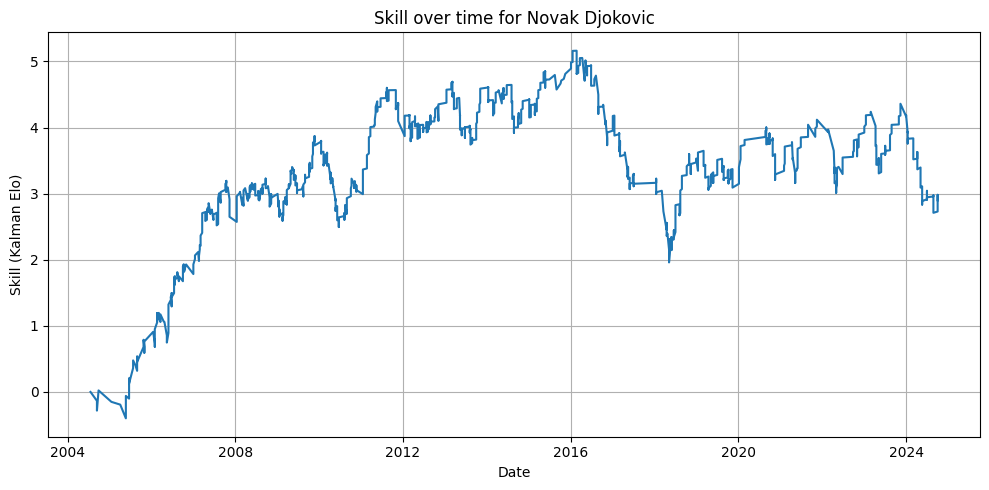

In [17]:
player_df = plot_player_elo(skill_df, player_name="Novak Djokovic")

### 3. Surface Specific Skill

The natural extension to the kalman state is to add the surface specific skill of certain players. There are three main surfaces: Hard, Clay and Grass.

To encode this in the Kalman State, each player will be represented as $x_a = [g_a, \delta^{clay}_a, \delta^{grass}_a, \delta^{hard}_a]^T$, where $\delta^{s}_a$ represents the skill deviation from the global skill for the specific surface.

Hence, the skill for a player given surface context is $s_a = g_a + \delta^{s}_a$.

Similar to global skill, we model the surface differentials as randomly drifting around. However unlike the global skill, the surface differentials will slowly shrink back to 0. This models how the surface specific performance should closley resemble the global performance of the player. This way, if a player stops playing on clay, $\delta^{clay}$ slowly shrinks back toward 0 automatically.

$$ g_t = g_{t-1} + w_g$$
$$\delta_t^s = \phi^{\Delta t}\delta_{t-1}^s+w_s, \space 0\gt\phi\lt 1$$

Each surface differential also maintains its own uncertainty, and the uncertainty grows proportional to time since last observation. 

$$P_a = diag(\sigma^2_g, \sigma^2_{clay}, \sigma^2_{grass}, \sigma^2_{hard})$$
$$P = \begin{bmatrix} P_A & 0 \\ 0 & P_B \end{bmatrix}$$

#### Prior Construction

For our prior, we assume the differentials have moved closer towards 0, scaled by time since the last observation.

$$
x^- =
\begin{bmatrix}
x_a^- \\
x_b^-
\end{bmatrix}
=
\begin{bmatrix}
F_a & 0 \\
0 & F_b
\end{bmatrix}
\begin{bmatrix}
x_a \\
x_b
\end{bmatrix},
$$

where for each player, 
$$
F_i = \mathrm{diag}\!\left(1,\;\phi^{\Delta t},\;\phi^{\Delta t},\;\phi^{\Delta t}\right),
\qquad
x_i =
\begin{bmatrix}
g_i \\
\delta_i^{\text{clay}} \\
\delta_i^{\text{grass}} \\
\delta_i^{\text{hard}}
\end{bmatrix}.
$$

The predicted covariance is given by,
$$
P^- =
\begin{bmatrix}
F_a & 0 \\
0 & F_b
\end{bmatrix}
P
\begin{bmatrix}
F_a & 0 \\
0 & F_b
\end{bmatrix}^{\!T}
+
Q(\Delta t),
$$

where $Q(\Delta t)$ is a diagonal matrix scaled by the time since last observation.

To predict the match win probability on a given surface, we first determine the effective skill on surface s:

$$s_a = g_a + \delta^s_a, \space s_b = g_b + \delta^s_b$$

The predicted probability player A wins is given as,

$$\hat{y}^- = h(x^-),\space h(x) = \sigma(kd_s^Tx)$$

Here $d_s$ is a selection vector depending on the surface. We choose $d_s$ to match our calculation of the effective skill on surface s.

$$
d_s \in \left\{
\begin{aligned}
d_{\text{clay}}  &= [\,1\;1\;0\;0\;-1\;-1\;0\;0\,],\\
d_{\text{grass}} &= [\,1\;0\;1\;0\;-1\;0\;-1\;0\,],\\
d_{\text{hard}}  &= [\,1\;0\;0\;1\;-1\;0\;0\;-1\,].
\end{aligned}
\right.
$$




Again, because $h$ is non-linear, we use an EKF approximation, $h(x) \approx h(x^-) + H(x - x^-)$, where H is the jacobian of h evaluated at $x^-$.

Let $p^-=h(x^-)$. It can be shown that

$$H = kp^-(1-p^-)d_s.$$

We gain compute the kalman gain:
$$S=HP^-H^T + R$$
$$K = P^-H^TS^{-1}$$

Here $R$ represents the noise from the result of the match. We are approximating the result of the match as
$$r \approx h(x^-) + v, \space v \sim N(0, R).$$

Similar to above, a natural choice of $R$ is $R = \hat{y}^-(1-\hat{y}^-)$ to approximate the Bernoulli observation noise by a Gaussian with the same variance.

Finally, we update the posterior
$$x^+ = x^- + Ke, \space e = r - \hat{y}^-$$
$$P^+ = (I - KH)P^-$$
where $r$ is the result. 1 if A wins, 0 if A loses.


In [ ]:
import numpy as np
import pandas as pd

def kalman_filter_surface(df):
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    # x_i = [g, d_clay, d_grass, d_hard]^T
    IDX = {"g": 0, "clay": 1, "grass": 2, "hard": 3}

    # Selector row vectors d_s
    def d_selector(surface):
        if surface == "clay":
            return np.array([[1, 1, 0, 0, -1, -1, 0, 0]], dtype=float)
        if surface == "grass":
            return np.array([[1, 0, 1, 0, -1, 0, -1, 0]], dtype=float)
        # default hard
        return np.array([[1, 0, 0, 1, -1, 0, 0, -1]], dtype=float)

    x = {}
    P = {}
    last_date = {}

    df = df.copy()
    df["tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")

    df["g_a"] = 0.0
    df["g_b"] = 0.0
    df["eff_skill_a"] = 0.0
    df["eff_skill_b"] = 0.0
    df["eff_var_a"] = 0.0
    df["eff_var_b"] = 0.0
    df["p_pred"] = 0.0

    init_x = np.zeros(4, dtype=float)
    init_P = np.diag([0.50, 0.20, 0.20, 0.20]).astype(float)  # global more uncertain than offsets

    # mean reversion for surface differentials
    phi = 0.995

    # global drift and offset drift
    q_g = 1e-4
    q_d = 5e-5

    # observation scale + noise floor
    k_elo = 1.0
    eps_R = 1e-4

    # effective skill calculation
    def eff_skill_and_var(xi, Pi, surface):
        v = np.zeros((4, 1))
        v[IDX["g"], 0] = 1.0
        v[IDX[surface], 0] = 1.0
        mu = (v.T @ xi.reshape(-1, 1)).item()
        var = (v.T @ Pi @ v).item()
        return mu, var

    for idx, row in df.iterrows():
        ida = row["id_a"]
        idb = row["id_b"]
        surface = str(row.get("surface", "hard")).lower()
        if surface not in ("clay", "grass", "hard"):
            surface = "hard"

        # init players
        if ida not in x:
            x[ida] = init_x.copy()
            P[ida] = init_P.copy()
            last_date[ida] = row["tourney_date"]
        if idb not in x:
            x[idb] = init_x.copy()
            P[idb] = init_P.copy()
            last_date[idb] = row["tourney_date"]

        # prediction step
        dta = max((row["tourney_date"] - last_date[ida]).days, 0)
        dtb = max((row["tourney_date"] - last_date[idb]).days, 0)

        Fa = np.diag([1.0, phi**dta, phi**dta, phi**dta])
        Fb = np.diag([1.0, phi**dtb, phi**dtb, phi**dtb])

        Qa = np.diag([q_g * dta, q_d * dta, q_d * dta, q_d * dta])
        Qb = np.diag([q_g * dtb, q_d * dtb, q_d * dtb, q_d * dtb])

        xa = Fa @ x[ida]
        xb = Fb @ x[idb]
        Pa = Fa @ P[ida] @ Fa.T + Qa
        Pb = Fb @ P[idb] @ Fb.T + Qb

        # log current state into df
        mu_a, var_a = eff_skill_and_var(xa, Pa, surface)
        mu_b, var_b = eff_skill_and_var(xb, Pb, surface)

        df.loc[idx, "g_a"] = xa[IDX["g"]]
        df.loc[idx, "g_b"] = xb[IDX["g"]]
        df.loc[idx, "eff_skill_a"] = mu_a
        df.loc[idx, "eff_skill_b"] = mu_b
        df.loc[idx, "eff_var_a"] = var_a
        df.loc[idx, "eff_var_b"] = var_b

        # build match-level state
        x8 = np.concatenate([xa, xb]).reshape(8, 1)
        P8 = np.zeros((8, 8), dtype=float)
        P8[:4, :4] = Pa
        P8[4:, 4:] = Pb

        # observation model
        ds = d_selector(surface)
        z = (k_elo * (ds @ x8)).item()
        p = float(sigmoid(z))
        p = float(np.clip(p, 1e-6, 1 - 1e-6))
        df.loc[idx, "p_pred"] = p

        # jacobian
        H = (k_elo * p * (1.0 - p)) * ds

        # approximate observation noise
        R = max(p * (1.0 - p), eps_R)

        # kalman gain
        S = (H @ P8 @ H.T).item() + R
        S = max(S, 1e-12)
        K = (P8 @ H.T) / S

        # update
        r = float(row["result"])
        e = r - p
        x8_post = x8 + K * e

        # use joseph covariance update for stability
        I8 = np.eye(8)
        KH = K @ H
        P8_post = (I8 - KH) @ P8 @ (I8 - KH).T + (K * R) @ K.T

        x[ida] = x8_post[:4, 0]
        x[idb] = x8_post[4:, 0]
        P[ida] = P8_post[:4, :4]
        P[idb] = P8_post[4:, 4:]
        last_date[ida] = row["tourney_date"]
        last_date[idb] = row["tourney_date"]

    return df


In [27]:
surface_skill_df = kalman_filter_surface(df)

In [31]:
display_top_elo_players_flex(surface_skill_df, elo_a_col="g_a", elo_b_col="g_b")

 player_id        player_name      elo
    104925     Novak Djokovic 2.863406
    206173      Jannik Sinner 2.668629
    207989     Carlos Alcaraz 2.399722
    104745       Rafael Nadal 2.203105
    106421    Daniil Medvedev 2.019589
    100644   Alexander Zverev 2.001183
    126203       Taylor Fritz 1.599971
    126774 Stefanos Tsitsipas 1.554762
    200282     Alex De Minaur 1.554394
    105777    Grigor Dimitrov 1.547033


,player_id,player_name,elo
7,104925,Novak Djokovic,2.863406
188,206173,Jannik Sinner,2.668629
210,207989,Carlos Alcaraz,2.399722
3,104745,Rafael Nadal,2.203105
67,106421,Daniil Medvedev,2.019589
0,100644,Alexander Zverev,2.001183
109,126203,Taylor Fritz,1.599971
119,126774,Stefanos Tsitsipas,1.554762
162,200282,Alex De Minaur,1.554394
28,105777,Grigor Dimitrov,1.547033


### Data Visualisation

In [29]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def display_top_elo_players_flex(
    df: pd.DataFrame,
    n: int = 10,
    *,
    id_a_col: str = "id_a",
    id_b_col: str = "id_b",
    name_a_col: str = "name_a",
    name_b_col: str = "name_b",
    elo_a_col: str = "skill_a",         
    elo_b_col: str = "skill_b",         
    date_col: str = "tourney_date",
    surface_col: str = "surface",      
    surface: str | None = None,        
    exclude_surfaces: tuple = ("Carpet",),
    as_of_date: str | None = None,     #
    active_window_days: int = 365,
) -> pd.DataFrame:
    """
    Shows top players by a given Elo (overall or surface-specific) as of a given date.
    Only includes players who played within the last `active_window_days`
    before `as_of_date`.

    Parameters
    ----------
    elo_a_col, elo_b_col
        Columns to use for Elo (e.g. "elo_a"/"elo_b" or "elo_surface_a"/"elo_surface_b").
    surface
        If provided, filter to matches on this surface only (e.g. "Grass").
    exclude_surfaces
        Surfaces to drop entirely (defaults to excluding "Carpet").
    """

    df = df.copy()

    # Optional surface filtering
    if surface_col in df.columns:
        if exclude_surfaces:
            df = df[~df[surface_col].isin(exclude_surfaces)]
        if surface is not None:
            df = df[df[surface_col] == surface]

    # Figure out cutoff date
    if as_of_date is None:
        cutoff_date = df[date_col].max()
    else:
        cutoff_date = datetime.strptime(as_of_date, "%Y%m%d")

    active_after = cutoff_date - timedelta(days=active_window_days)

    # Filter to matches up to the as_of_date
    df = df[df[date_col] <= cutoff_date]

    # Build long format using the chosen Elo columns
    a_side = df[[id_a_col, name_a_col, elo_a_col, date_col]].rename(
        columns={
            id_a_col: "player_id",
            name_a_col: "player_name",
            elo_a_col: "elo",
        }
    )
    b_side = df[[id_b_col, name_b_col, elo_b_col, date_col]].rename(
        columns={
            id_b_col: "player_id",
            name_b_col: "player_name",
            elo_b_col: "elo",
        }
    )

    long_df = pd.concat([a_side, b_side], ignore_index=True)
    long_df = long_df.dropna(subset=["elo"])

    # Filter to only players active within X days before cutoff
    recent_matches = long_df[long_df[date_col] >= active_after]
    active_players = set(recent_matches["player_id"].unique())
    long_df = long_df[long_df["player_id"].isin(active_players)]

    # For each player, take their latest Elo before cutoff
    latest_elo = (
        long_df
        .sort_values(date_col)
        .groupby("player_id", as_index=False)
        .last()[["player_id", "player_name", "elo"]]
    )

    top_players = latest_elo.sort_values("elo", ascending=False).head(n)

    print(top_players.to_string(index=False))
    return top_players

def plot_player_elo(df: pd.DataFrame, player_id=None, player_name=None):
    """
    Plot Kalman/Elo skill over time for a single player.

    Either player_id or player_name must be provided.
    Assumes df has columns:
    - 'tourney_date' as int YYYYMMDD
    - 'id_a', 'id_b'
    - 'name_a', 'name_b'
    - 'skill_a', 'skill_b'
    """
    if player_id is None and player_name is None:
        raise ValueError("Provide either player_id or player_name.")
    
    df = df.copy()

    if player_id is not None:
        mask_a = df["id_a"] == player_id
        mask_b = df["id_b"] == player_id
        player_label = str(player_id)
    else:
        mask_a = df["name_a"] == player_name
        mask_b = df["name_b"] == player_name
        player_label = player_name

    mask = mask_a | mask_b
    player_df = df[mask].copy()
    if player_df.empty:
        print(f"No matches found for player {player_label}")
        return

    # for each row, pick skill_a if they are A, else skill_b
    player_df["is_a"] = mask_a[mask]
    player_df["elo"] = np.where(player_df["is_a"], player_df["skill_a"], player_df["skill_b"])

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(player_df["tourney_date"], player_df["elo"], linestyle="-")
    plt.xlabel("Date")
    plt.ylabel("Skill (Kalman Elo)")
    plt.title(f"Skill over time for {player_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return player_df  # handy if you want to inspect the underlying data
